In [2]:
import pmdarima

In [32]:
import pandas as pd
import numpy as np

In [48]:
df = pd.read_csv('house_sales.csv', index_col='datesold', parse_dates=True)
df = df[df['propertyType'] == 'house']
df = df[["price"]]
df = df.groupby(pd.Grouper(freq='ME')).mean()
df.index = df.index.to_period('M').to_timestamp('M')
df.shape

(150, 1)

<Axes: xlabel='datesold'>

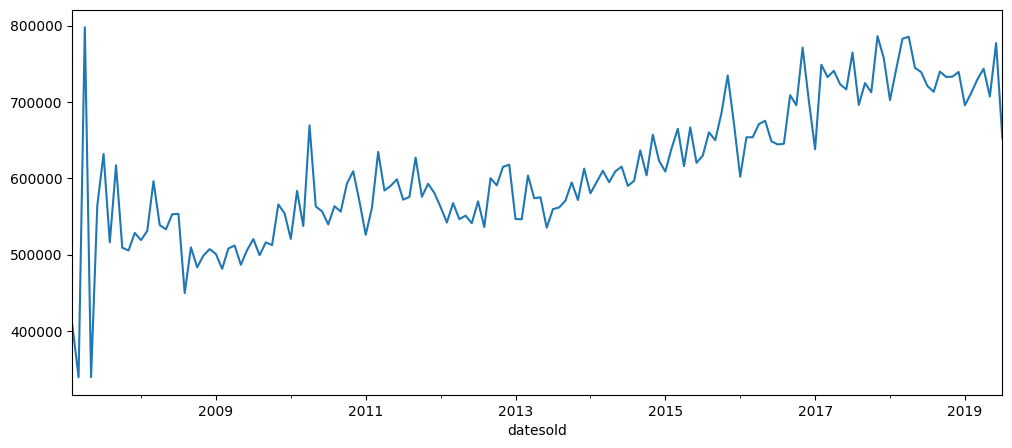

In [49]:
df['price'].plot(figsize=(12,5))

In [99]:
from statsmodels.tsa.stattools import adfuller
adfuller(df, autolag= "AIC")

(-0.3071589989275587,
 0.9244842660450305,
 13,
 136,
 {'1%': -3.4793722137854926,
  '5%': -2.8830370378332995,
  '10%': -2.578233635380623},
 3198.834326465154)

In [100]:
from pmdarima import auto_arima

In [101]:
stepwise_fit = auto_arima(df["price"], seasonal=True, m=12, trace=True, suppress_warnings=True, test='adf')
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3753.664, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3683.529, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3772.492, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3751.748, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3689.710, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3685.002, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3683.377, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3684.135, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3685.239, Time=0.23 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3685.358, Time=0.19 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3686.133, Time=0.12 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=3684.426, Time=0.27 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3753.760, Time=0.08 sec
 ARIMA(2,1,0)(1,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  150
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1835.491
Date:                              Tue, 06 Feb 2024   AIC                           3678.982
Time:                                      14:16:16   BIC                           3690.998
Sample:                                  02-28-2007   HQIC                          3683.864
                                       - 07-31-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5770      0.026    -22.187      0.000      -0.628      -0.526
ar.S.L12       0.8916      0.113      7.874      0.000       0.670       1.113
ma.S.L12      -0.7526      0.173     -4.343      0.000      -1.092      -0.413
sigma2      3.037e+09   1.09e-10    2.8e+19      0.000    3.04e+09    3.04e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.81   Jarque-Bera (JB):              2838.93
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+34. Standard errors may be unstable.
"""

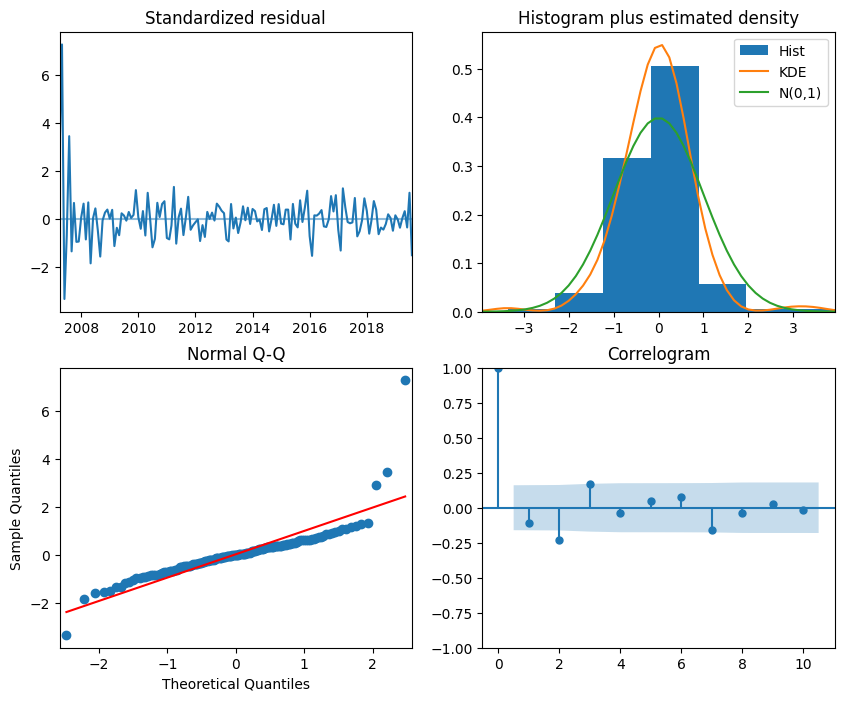

In [102]:
from matplotlib import pyplot as plt
from pmdarima.model_selection import train_test_split
stepwise_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [114]:
train, test = train_test_split(df, test_size=10)
n_periods = len(test)
forecast, conf_int = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True)

In [115]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [116]:
print(df.shape)

(150, 1)


In [117]:
train = df.iloc[:-10]
test = df.iloc[-10:]
train, test

(                    price
 datesold                 
 2007-02-28  407500.000000
 2007-03-31  339333.333333
 2007-04-30  798000.000000
 2007-05-31  339500.000000
 2007-06-30  564400.000000
 ...                   ...
 2018-05-31  744829.602374
 2018-06-30  739061.220472
 2018-07-31  720939.214286
 2018-08-31  713360.850000
 2018-09-30  739834.319249
 
 [140 rows x 1 columns],
                     price
 datesold                 
 2018-10-31  732847.113208
 2018-11-30  733213.016736
 2018-12-31  739387.214286
 2019-01-31  695679.166667
 2019-02-28  711578.000000
 2019-03-31  729635.593220
 2019-04-30  743605.694268
 2019-05-31  707236.011905
 2019-06-30  777167.525773
 2019-07-31  652604.879121)

In [118]:
modelSA = SARIMAX(train['price'], 
                order=(1, 1, 0),                # Non-seasonal order
                seasonal_order=(1, 0, 1, 12)) 
modelSA = modelSA.fit()
modelSA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                price   No. Observations:                  140
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1715.129
Date:                              Tue, 06 Feb 2024   AIC                           3438.257
Time:                                      14:17:56   BIC                           3449.995
Sample:                                  02-28-2007   HQIC                          3443.027
                                       - 09-30-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5678      0.027    -20.827      0.000      -0.621      -0.514
ar.S.L12       0.8879      0.119      7.488      0.000       0.656       1.120
ma.S.L12      -0.7449      0.181     -4.124      0.000      -1.099      -0.391
sigma2      3.164e+09   1.14e-10   2.77e+19      0.000    3.16e+09    3.16e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):              2567.18
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+34. Standard errors may be unstable.
"""

datesold
2018-10-31    731769.474291
2018-11-30    761135.777742
2018-12-31    742908.334573
2019-01-31    715317.445923
2019-02-28    742939.279407
2019-03-31    752975.108214
2019-04-30    754243.651158
2019-05-31    745636.034868
2019-06-30    739992.544075
2019-07-31    743086.264065
Freq: ME, Name: predicted_mean, dtype: float64


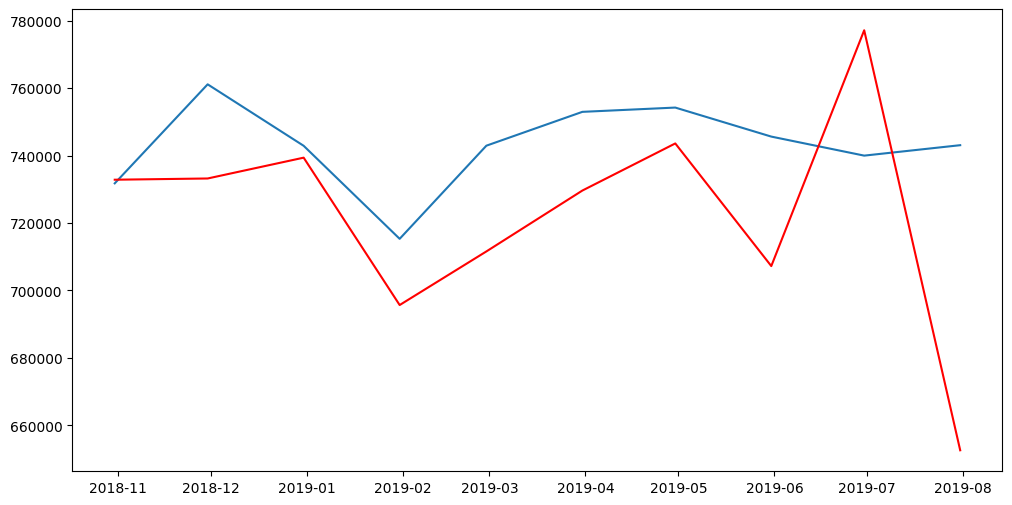

In [121]:
start = len(train)
end = len(train)+ len(test) - 1
pred = modelSA.predict(start=start, end=end)
pred.index=df.index[start:end+1]
plt.figure(figsize=(12, 6))
plt.plot(pred)
plt.plot(test, color = 'red')
print(pred)

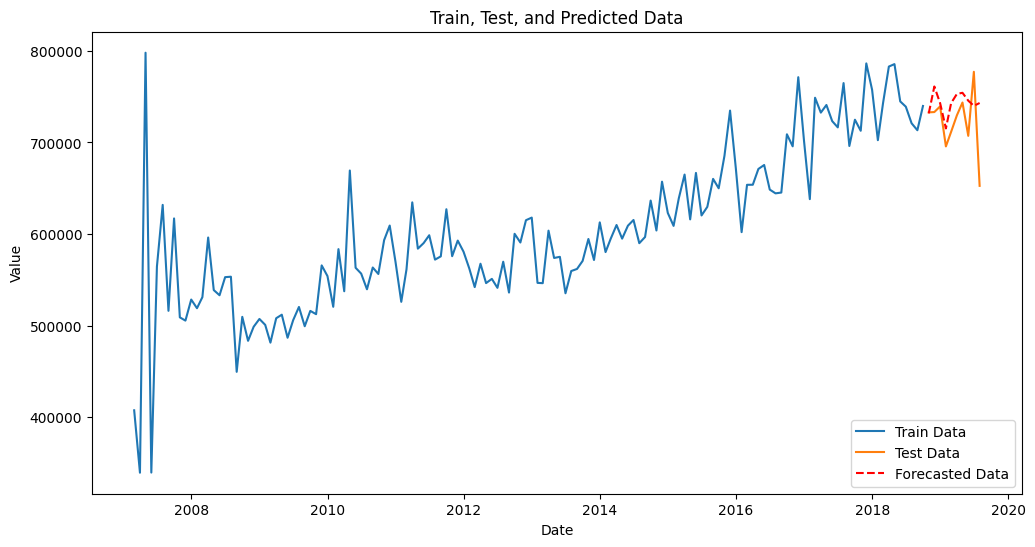

In [122]:
pred_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=len(test), freq=train.index.freq)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(pred_index, pred, label='Forecasted Data', color='red', linestyle='--')



plt.title('Train, Test, and Predicted Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [123]:
test['price'].mean()

722295.4215183022

In [124]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['price']))
print(rmse)

37234.061248189086


NOW WE CAN PREDICT FUTURE VALUES WITH GOOD ACCURACY

In [125]:
FUTURE_MODEL = SARIMAX(df['price'],order=(1, 1, 0),                # Non-seasonal order
                seasonal_order=(1, 0, 1, 12))
FUTURE_MODEL = FUTURE_MODEL.fit()
df.tail()

,price
datesold,
2019-03-31,729635.593220
2019-04-30,743605.694268
2019-05-31,707236.011905
2019-06-30,777167.525773
2019-07-31,652604.879121


In [126]:
start = len(df)
end = len(df)+ 30
pred = modelSA.predict(start=start, end=end)
print(pred)

2019-08-31    734554.145276
2019-09-30    751698.742832
2019-10-31    748149.656807
2019-11-30    772173.303434
2019-12-31    757153.488979
2020-01-31    731994.580245
2020-02-29    756895.243408
2020-03-31    765592.927136
2020-04-30    766840.253497
2020-05-31    759128.882202
2020-06-30    754157.047458
2020-07-31    756881.806885
2020-08-31    749318.738257
2020-09-30    764534.234750
2020-10-31    761387.065423
2020-11-30    782715.285852
2020-12-31    769380.545547
2021-01-31    747041.286238
2021-02-28    769150.929449
2021-03-31    776873.336849
2021-04-30    777980.969860
2021-05-31    771133.989983
2021-06-30    766719.557023
2021-07-31    769138.837660
2021-08-31    762423.626468
2021-09-30    775933.410852
2021-10-31    773139.053465
2021-11-30    792076.312004
2021-12-31    780236.438691
2022-01-31    760401.478435
2022-02-28    780032.562906
Freq: ME, Name: predicted_mean, dtype: float64


<Axes: >

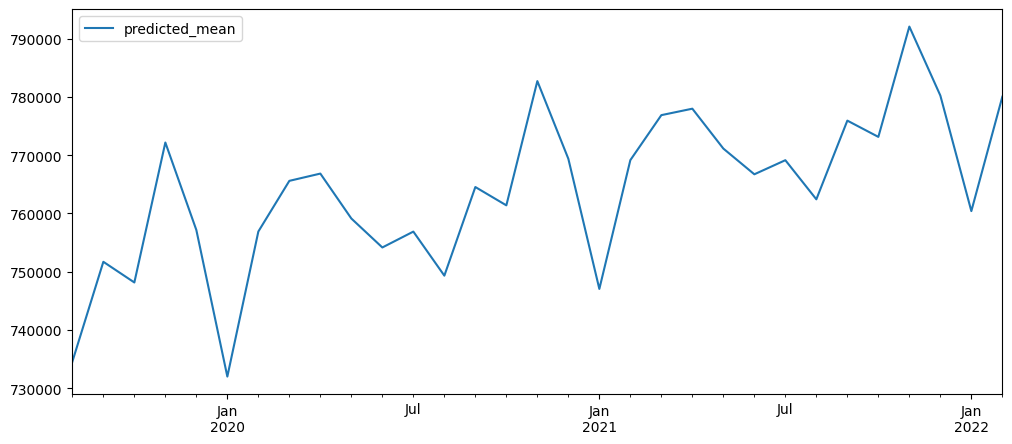

In [127]:
pred.plot(figsize=(12,5), legend=True)